In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Path to dataset
data_dir = "/kaggle/input/cucumber-disease/cucumber_disease"

# Transformations (resize + tensor + normalization for VGG16)
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # VGG16 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Dataset sizes
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)   # 80%
val_size   = int(0.1 * dataset_size)   # 10%
test_size  = dataset_size - train_size - val_size  # remaining 10%

# Split directly into train, val, test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Class names
class_names = dataset.classes
print("Classes:", class_names)
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Pythium Fruit Rot']
Train samples: 903, Val samples: 112, Test samples: 114


In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# ======================
# Hyperparameters
# ======================
batch_size = 32
epochs = 15
image_size = 224  

# Path to dataset
data_dir = "/kaggle/input/cucumber-disease/cucumber_disease"

# Transformations (resize + tensor + normalization for VGG16)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Dataset sizes
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)   # 80%
val_size   = int(0.1 * dataset_size)   # 10%
test_size  = dataset_size - train_size - val_size  # 10%

# Split directly into train, val, test
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class names
class_names = dataset.classes
print("Classes:", class_names)
print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")


Classes: ['Anthracnose', 'Bacterial Wilt', 'Belly Rot', 'Downy Mildew', 'Fresh Cucumber', 'Fresh Leaf', 'Pythium Fruit Rot']
Train samples: 903, Val samples: 112, Test samples: 114


In [3]:
import torch
import torch.nn as nn
import timm  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load pretrained Xception
# -----------------------------
model = timm.create_model("xception", pretrained=True)

# -----------------------------
# Freeze all layers
# -----------------------------
for param in model.parameters():
    param.requires_grad = False

# -----------------------------
# Unfreeze last 30% layers
# -----------------------------
layers = list(model.children())[:-1]  # get all feature layers except classifier
num_layers = len(layers)
unfreeze_from = int(num_layers * 0.7)

for layer in layers[unfreeze_from:]:
    for param in layer.parameters():
        param.requires_grad = True

# -----------------------------
# Replace classifier
# -----------------------------
num_classes = 7
in_features = model.get_classifier().in_features  # timm helper works here
model.reset_classifier(num_classes=num_classes)   # cleaner way than manual nn.Linear

model = model.to(device)

# -----------------------------
# Loss & Optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), 
    lr=0.0001
)


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [4]:
from tqdm import tqdm

def train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device, aux_logits=False):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # -----------------------------
        # Training phase
        # -----------------------------
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        loop = tqdm(train_loader, leave=False)

        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            if aux_logits and isinstance(outputs, tuple):
                # InceptionV3 (main + auxiliary output)
                main_outputs, aux_outputs = outputs
                loss1 = criterion(main_outputs, labels)
                loss2 = criterion(aux_outputs, labels)
                loss = loss1 + 0.4 * loss2   # weighted sum
                preds = torch.max(main_outputs, 1)[1]
            else:
                # Normal models
                loss = criterion(outputs, labels)
                preds = torch.max(outputs, 1)[1]

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_description(f"Train Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        train_loss = running_loss / total
        train_acc = correct / total

        # -----------------------------
        # Validation phase
        # -----------------------------
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                if aux_logits and isinstance(outputs, tuple):
                    outputs = outputs[0]  # only use main output for validation

                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = torch.max(outputs, 1)[1]
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history
history = train_model(model, criterion, optimizer, train_loader, val_loader, epochs, device)


Epoch 1/15


Epoch 1/15 - Train Loss: 1.4946, Train Acc: 0.6456, Val Loss: 0.7940, Val Acc: 0.8661

Epoch 2/15


Epoch 2/15 - Train Loss: 0.6985, Train Acc: 0.8870, Val Loss: 0.3597, Val Acc: 0.9286

Epoch 3/15


Epoch 3/15 - Train Loss: 0.3732, Train Acc: 0.9336, Val Loss: 0.2245, Val Acc: 0.9464

Epoch 4/15


Epoch 4/15 - Train Loss: 0.2326, Train Acc: 0.9546, Val Loss: 0.1825, Val Acc: 0.9643

Epoch 5/15


Epoch 5/15 - Train Loss: 0.1678, Train Acc: 0.9668, Val Loss: 0.1648, Val Acc: 0.9643

Epoch 6/15


Epoch 6/15 - Train Loss: 0.1237, Train Acc: 0.9845, Val Loss: 0.1382, Val Acc: 0.9643

Epoch 7/15


Epoch 7/15 - Train Loss: 0.0835, Train Acc: 0.9922, Val Loss: 0.1416, Val Acc: 0.9643

Epoch 8/15


Epoch 8/15 - Train Loss: 0.0615, Train Acc: 0.9911, Val Loss: 0.1292, Val Acc: 0.9643

Epoch 9/15


Epoch 9/15 - Train Loss: 0.0444, Train Acc: 0.9956, Val Loss: 0.1426, Val Acc: 0.9554

Epoch 10/15


Epoch 10/15 - Train Loss: 0.0399, Train Acc: 0.9945, Val Loss: 0.1276, Val Acc: 0.9643

Epoch 11/15


Epoch 11/15 - Train Loss: 0.0319, Train Acc: 0.9967, Val Loss: 0.1369, Val Acc: 0.9554

Epoch 12/15


Epoch 12/15 - Train Loss: 0.0321, Train Acc: 0.9978, Val Loss: 0.1180, Val Acc: 0.9643

Epoch 13/15


Epoch 13/15 - Train Loss: 0.0213, Train Acc: 0.9989, Val Loss: 0.1317, Val Acc: 0.9643

Epoch 14/15


Epoch 14/15 - Train Loss: 0.0218, Train Acc: 0.9978, Val Loss: 0.1252, Val Acc: 0.9643

Epoch 15/15


Epoch 15/15 - Train Loss: 0.0286, Train Acc: 0.9978, Val Loss: 0.1349, Val Acc: 0.9643


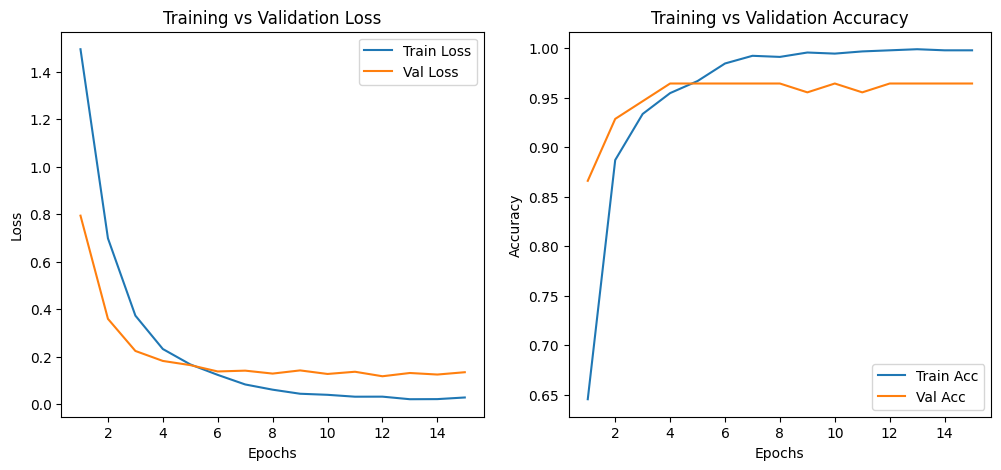

In [5]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.show()

plot_history(history)


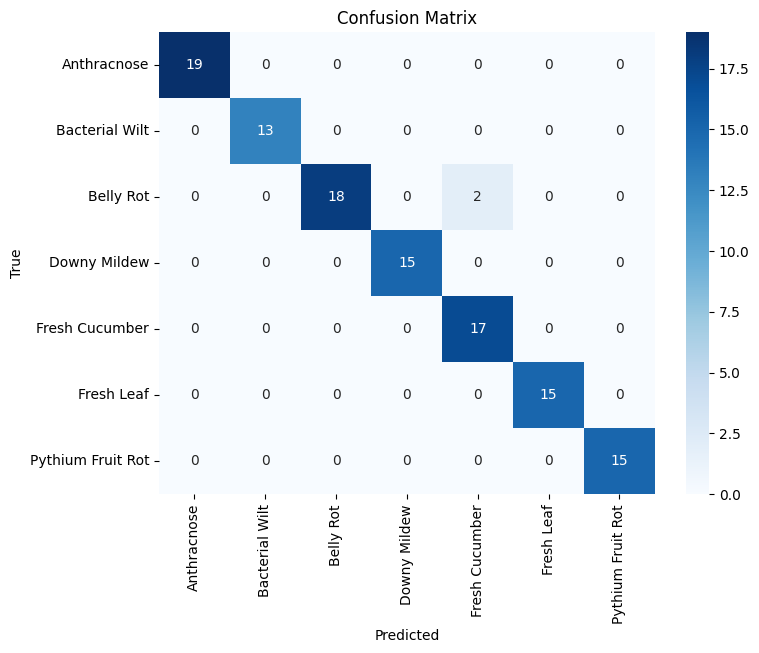


Classification Report:

                   precision    recall  f1-score   support

      Anthracnose       1.00      1.00      1.00        19
   Bacterial Wilt       1.00      1.00      1.00        13
        Belly Rot       1.00      0.90      0.95        20
     Downy Mildew       1.00      1.00      1.00        15
   Fresh Cucumber       0.89      1.00      0.94        17
       Fresh Leaf       1.00      1.00      1.00        15
Pythium Fruit Rot       1.00      1.00      1.00        15

         accuracy                           0.98       114
        macro avg       0.98      0.99      0.98       114
     weighted avg       0.98      0.98      0.98       114



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def evaluate_model(model, test_loader, class_names, device):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Test
evaluate_model(model, test_loader, class_names, device)
